# Drug Discovery using ChEMBL

ChEMBL is a curated chemical database of *bioactive* molecules with *druglike* properties.

**bioactive**: has an effect on a living organism, tissue or cell

**druglikeness**: a qualitative factor used in drug design; how "druglike" a substance is with respect to factors estimated from the molecular structure

#### Table of contents

1.   [Research](#Research)
2.   [Acquire & prepare molecular data](#Acquire)
.   [Modeling the chemical fingerprints](#Model)



In [1]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from source.prepare import preprocess_bioactivity_data

%load_ext autoreload
%autoreload 2

<a id='Research'></a>
## Preliminary research


In October, 2021, [*Nature* reported](https://www.nature.com/articles/d41586-021-02755-5#ref-CR2), `More than 130 years after the naming of the Plasmodium parasites behind malaria, the world now has its first approved vaccine against them ... Compared with other childhood vaccinations, RTS,S has only modest efficacy, preventing about 30% of severe malaria cases after a series of four injections in children under the age of five. Nevertheless, one modelling study suggests that it could prevent the deaths of 23,000 children a year ... [malaria] killed 411,000 people in 2018.`

According to the [CDC website](https://www.cdc.gov/malaria/about/biology/index.html#tabs-1-6), `Four species of Plasmodium have long been recognized to infect humans in nature. In addition there is one species that naturally infects macaques which has recently been recognized to be a cause of zoonotic malaria in humans ... P. knowlesi is found throughout Southeast Asia as a natural pathogen of long-tailed and pig-tailed macaques. It has a 24-hour replication cycle and so can rapidly progress from an uncomplicated to a severe infection; fatal cases have been reported.`

![](https://www.cdc.gov/malaria/images/microscopy/about/falciparum.jpg)

(P. falciparum, the deadliest species, targeted by new vaccine)

![](https://www.cdc.gov/malaria/images/microscopy/about/knowlesi.jpg)

(P. knowlesi, newly found to cause zoonotic malaria in humans infected by primates)

Is [Plasmodium knowlesi](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL613011/) in the ChEMBL database? If so, we can use it to retrieve the microorganism's assays, which are chemical tests made to estimate the **potency** of sample compounds on the organism. We can check using the ChEMBL group's official Python client library... 

In [5]:
drug_target = 'Plasmodium knowlesi'
#OR skip this step if you already know the molecule ID
target_dicts = []
res = new_client.target.search(drug_target)
for r in res:
    target_dicts.append({'organism': r['organism'],
                         'pref_name': r['pref_name'],
                         'target_chembl_id': r['target_chembl_id']})
#P. knowlesi is the top search result, other species listed below
target_dicts[:5]

[{'organism': 'Plasmodium knowlesi',
  'pref_name': 'Plasmodium knowlesi',
  'target_chembl_id': 'CHEMBL613011'},
 {'organism': 'Homo sapiens',
  'pref_name': 'Duffy antigen/chemokine receptor',
  'target_chembl_id': 'CHEMBL2321626'},
 {'organism': 'Plasmodium falciparum',
  'pref_name': 'Plasmodium falciparum',
  'target_chembl_id': 'CHEMBL364'},
 {'organism': 'Plasmodium berghei',
  'pref_name': 'Plasmodium berghei',
  'target_chembl_id': 'CHEMBL612653'},
 {'organism': 'Plasmodium yoelii',
  'pref_name': 'Plasmodium yoelii',
  'target_chembl_id': 'CHEMBL612889'}]

<a id='Acquire'></a>
### Acquire & prepare molecular data

This cell will create **two csv files** based on the ChEMBL ID:

* preprocessed data with SMILES notation and added columns for Lapinski descriptors (druglike properties), $pIC_{50}$ values (potency, the dependent variable), and a binary class variable ('ACTIVE', 'INACTIVE') indicating whether or not each molecule is reactive with the target

* the chemical fingerprint, 881-digit binary representation of the molecular structure based on atoms and bonds, for each molecule in the dataset that is used for training the machine learning algorithm to identify promising molecules

Dependencies include the ChEMBL Webresource Client, RDKit, and PaDELPy

In [6]:
#If you know the molecule ID, set it here and uncomment below.
#target_id = 'CHEMBL613011'
#Or if you want to use the search results, run this cell as is.
target_id = target_dicts[0]['target_chembl_id']

In [7]:
preprocess_bioactivity_data(target_id, tests=False, fingerprints=True)


Query results retrieved for CHEMBL613011...
Saving 9 molecules.

Computing fingerprints (takes several minutes if molecules > 1000)...
Success!



In [8]:
bioactivity_df = pd.read_csv(f'{target_id}_bioactivity_preprocessed.csv')
bioactivity_df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1951761,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@H](C)N,10500.0,INACTIVE,301.515,4.14660,3.0,3.0,4.978811
1,CHEMBL1951763,CCCCCCCCCCCCC[C@H](O)C[C@@H](O)[C@H](C)N,20300.0,INACTIVE,301.515,4.14660,3.0,3.0,4.692504
2,CHEMBL1951762,CCCCCCCCCCCCC[C@@H](O)C[C@H](O)[C@H](C)N,17600.0,INACTIVE,301.515,4.14660,3.0,3.0,4.754487
3,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,10.0,ACTIVE,319.880,4.81060,1.0,3.0,8.000000
4,CHEMBL172,O[C@@H](c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)[C@...,40.0,ACTIVE,378.316,4.44790,2.0,3.0,7.397940
5,CHEMBL4166227,Clc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,ACTIVE,462.614,0.50020,0.0,3.0,7.096910
6,CHEMBL4174142,Fc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,ACTIVE,446.159,-0.01410,0.0,3.0,7.096910
7,CHEMBL4165957,N#Cc1ccc2c(c1)-c1ccccc1[I+]2.O=S(=O)([O-])C(F)...,110.0,ACTIVE,453.179,-0.28152,0.0,4.0,6.958607
8,CHEMBL4167328,O=S(=O)([O-])C(F)(F)F.c1ccc2c(c1)[I+]c1ccccc1-2,740.0,ACTIVE,428.169,-0.15320,0.0,3.0,6.130768


In [9]:
fingerprint_df = pd.read_csv(f'{target_id}_pubchem_fp.csv')
fingerprint_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL1951761,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1951763,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1951762,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL76,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL4166227,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,CHEMBL172,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,CHEMBL4174142,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,CHEMBL4165957,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,CHEMBL4167328,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### An example molecule from the dataset

In [ ]:
mol = bioactivity_df.molecule_chembl_id[3]
SMILES = bioactivity_df.canonical_smiles[bioactivity_df.molecule_chembl_id==mol].values[0]
fingerprint = np.array(fingerprint_df[fingerprint_df.Name==mol])[0][1:]
print(f'Three representations of molecule {mol}:\n')
print('1. SMILES notation\n\n', SMILES)
print('\n2. Chemical fingerprint\n\n', fingerprint)
print('\n3. Drawing\n')
Chem.MolFromSmiles(SMILES) 

<a id='Explore'></a>
## Explore molecular descriptors

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

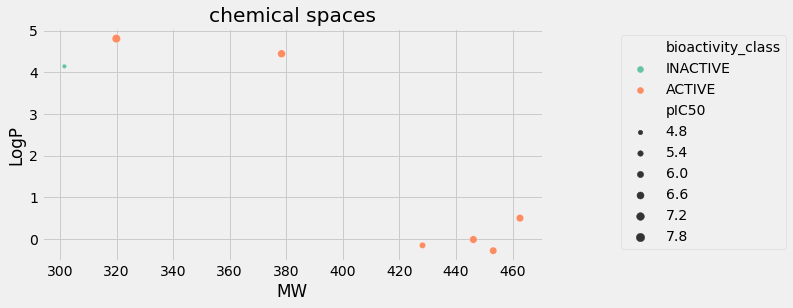

In [56]:
plt.figure(figsize=(8,4))
sns.scatterplot(x='MW', y='LogP', data=bioactivity_df,
                hue='bioactivity_class', size='pIC50',
                palette="Set2")
plt.legend(bbox_to_anchor=(1.5,1))
plt.title('chemical spaces')
plt.show()

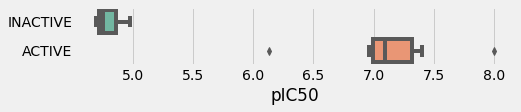

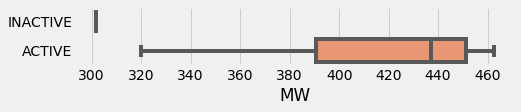

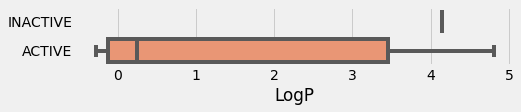

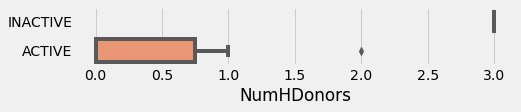

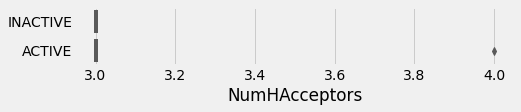

In [52]:
descriptors = ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
for desc in descriptors:
    plt.figsize = (10,1)
    ax = sns.boxplot(x=desc, y="bioactivity_class", data=bioactivity_df, palette="Set2")
    plt.ylabel('')
    plt.show()

<a id='Model'></a>
## Modeling the chemical fingerprints

In this part, we use machine learning to determine the charachteristics of molecules with a high chance of being viable drug candidates.

A note on modeling: $R^2$ is the percent of the variance in [potency](https://en.wikipedia.org/wiki/Potency_(pharmacology)) (as measured by $pIC_{50}$) is explained by the chemical fingerprint of the molecule.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

In [75]:
#important step to make sure dependent variable matches with molecule
modeling_df = fingerprint_df.merge(bioactivity_df, right_on='molecule_chembl_id', left_on='Name')
modeling_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP880,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1951761,1,1,1,1,0,0,0,0,0,...,0,CHEMBL1951761,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@H](C)N,10500.0,INACTIVE,301.515,4.14660,3.0,3.0,4.978811
1,CHEMBL1951763,1,1,1,1,0,0,0,0,0,...,0,CHEMBL1951763,CCCCCCCCCCCCC[C@H](O)C[C@@H](O)[C@H](C)N,20300.0,INACTIVE,301.515,4.14660,3.0,3.0,4.692504
2,CHEMBL1951762,1,1,1,1,0,0,0,0,0,...,0,CHEMBL1951762,CCCCCCCCCCCCC[C@@H](O)C[C@H](O)[C@H](C)N,17600.0,INACTIVE,301.515,4.14660,3.0,3.0,4.754487
3,CHEMBL76,1,1,1,0,0,0,0,0,0,...,0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,10.0,ACTIVE,319.880,4.81060,1.0,3.0,8.000000
4,CHEMBL4166227,1,0,0,0,0,0,0,0,0,...,0,CHEMBL4166227,Clc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,ACTIVE,462.614,0.50020,0.0,3.0,7.096910
5,CHEMBL172,1,1,1,0,0,0,0,0,0,...,0,CHEMBL172,O[C@@H](c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)[C@...,40.0,ACTIVE,378.316,4.44790,2.0,3.0,7.397940
6,CHEMBL4174142,1,0,0,0,0,0,0,0,0,...,0,CHEMBL4174142,Fc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,ACTIVE,446.159,-0.01410,0.0,3.0,7.096910
7,CHEMBL4165957,1,0,0,0,0,0,0,0,0,...,0,CHEMBL4165957,N#Cc1ccc2c(c1)-c1ccccc1[I+]2.O=S(=O)([O-])C(F)...,110.0,ACTIVE,453.179,-0.28152,0.0,4.0,6.958607
8,CHEMBL4167328,1,1,0,0,0,0,0,0,0,...,0,CHEMBL4167328,O=S(=O)([O-])C(F)(F)F.c1ccc2c(c1)[I+]c1ccccc1-2,740.0,ACTIVE,428.169,-0.15320,0.0,3.0,6.130768


In [84]:
X = modeling_df.iloc[:,1:-9] #fingerprint only
y = modeling_df['pIC50'] #response variable
y.describe()

count    9.000000
mean     6.345215
std      1.251389
min      4.692504
25%      4.978811
50%      6.958607
75%      7.096910
max      8.000000
Name: pIC50, dtype: float64

In [85]:
selector = VarianceThreshold(.1)
X = selector.fit_transform(X)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=36)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7, 149), (7,), (2, 149), (2,))

We've already dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Now try to maximize the cross-validation score.


In [87]:
rfr = RandomForestRegressor(n_estimators=100, ccp_alpha=.01, random_state=36)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=5)
print("Scores:", cv_scores)
print("Maximize the average:", round(cv_scores.mean(),3))

/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Scores: [ -2.19497877 -44.38440315          nan          nan          nan]
Maximize the average: nan


/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [90]:
dr = DummyRegressor(strategy='median').fit(X_train, y_train) #Baseline
#Evaluation
print("Baseline R^2:", round(dr.score(X_test, y_test),3))
rfr.fit(X_train, y_train)
print("Best model R^2:", round(rfr.score(X_test, y_test),3))

Baseline R^2: -0.509
Best model R^2: -0.886


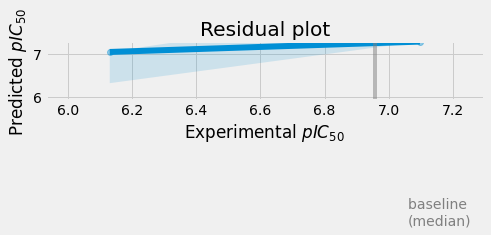

In [92]:
rf_preds = rfr.predict(X_test)

ax = sns.regplot(x=y_test, y=rf_preds, scatter_kws={'alpha':.4})
ax.axvline(y_train.median(), color='gray', alpha=.5)
ax.text(y_train.median()+.1, 3, 'baseline \n(median)', color='gray')
ax.set_xlabel('Experimental $pIC_{50}$')
ax.set_ylabel('Predicted $pIC_{50}$')
ax.set_title('Residual plot')
pIC50_range = (y_test.min()-.2, y_test.max()+.2)
ax.set_xlim(pIC50_range)
ax.set_ylim(pIC50_range)
plt.show()